# Instance generator for the problem

In [18]:
import random
import pandas as pd
import numpy as np

# Generate an instance for the problem
def inst_gen(n, seed):

  # setting seed
  random.seed(seed)

  # weights:
  weights = []

  for i in range(0,n):
    w = random.randint(1, 100)
    weights.append(w)

  # profits:
  profits = []

  for i in range(0,n):
    p = random.randint(1,100)
    profits.append(p)

  # dataframe:
  df = pd.DataFrame()
  df["Profit"] = profits
  df["Weights"] = weights
  df["Density"] = df["Profit"]/df["Weights"]

  # capacity of the knapsack:
  c = random.randint(np.floor((sum(weights)-1)*0.8),sum(weights)-1)

  # output:

  #print("Max capacity is: ", c)
  #print("Number of items is: ", n)
  df = df.sort_values("Density", ascending = False).reset_index(drop=True)
  return df, c



Test:

In [2]:
df, c = inst_gen(10, 3)

# Our greedy algorithm:

In [19]:
def greedy(df, c):
  profit = 0
  added_items = []
  i = 0
  while c >= df["Weights"][i]:
    # current profit
    profit += df["Profit"][i]
    # current list of added items
    added_items.append(i)
    # current residual capacity
    c -= df["Weights"][i]
    i += 1
  last_item_added = added_items[len(added_items)-1]
  #print("profit is: ", profit)
  #print("last item added was: ", last_item_added)
  return profit, last_item_added

Test:

In [ ]:
greedy(df, c)

#Optimal Solutions:

In [5]:
!pip install gurobipy
import numpy as np
import random
from gurobipy import Model,GRB,LinExpr

     |████████████████████████████████| 11.5 MB 9.8 MB/s 


In [20]:
def build_model(df,c):
    model = Model()
    
    n_items = df.shape[0]

    # Create the x variables
    x = model.addVars(n_items, vtype=GRB.BINARY, name='x')
    
    # Create the objective function: max < x, p >
    obj = LinExpr()
    for j in range(n_items):
      obj += x[j] * df['Profit'].to_list()[j]
    model.setObjective(obj, GRB.MAXIMIZE)
    
    # Create the constraint: < x, w > <= c
    for j in range(n_items):
      model.addConstr(sum([x[i]*df['Weights'].to_list()[i] for i in range(n_items)]) <= c)
    
    # Returns both the model object and the vars, to later access their value
    return model, x

Test:

In [7]:
model, x = build_model(df, c)
model.setParam( 'OutputFlag', False )
model.optimize()

fo=model.objVal

Restricted license - for non-production use only - expires 2023-10-25


# Comparing our model to gurobi's

In [24]:
import timeit
#number of items in the problem:
n = 200

#number of problems we want both models to solve:
max_i = 100

greedy_sols = []
greedy_times = []
optimal_sols = []
guroby_times = []

for i in range(0,max_i):
  if i%(max_i/10) == 0:
    print("ITERATION NUMBER: ", i)

  seed = random.randint(0, 1000000)
  #gen instance:
  df, c = inst_gen(n, seed)
  #get solution with greedy algorithm:
  start = timeit.timeit()
  x, _ = greedy(df, c)
  end = timeit.timeit()
  time = (end - start)

  #add greedy sol to list:
  greedy_sols.append(x)
  greedy_times.append(time)

  #get optimal sol
  
  model, x = build_model(df, c)
  model.setParam( 'OutputFlag', False )
  model.Params.Cuts = 0
  model.Params.Heuristics = 0
  model.Params.Presolve = 0
  start1 = timeit.timeit()
  model.optimize()
  fo=model.objVal
  
  end1 = timeit.timeit()
  time1 = (end1 - start1)

  #add optimal solution
  optimal_sols.append(fo)
  guroby_times.append(time1)

ITERATION NUMBER:  0
ITERATION NUMBER:  10
ITERATION NUMBER:  20
ITERATION NUMBER:  30
ITERATION NUMBER:  40
ITERATION NUMBER:  50
ITERATION NUMBER:  60
ITERATION NUMBER:  70
ITERATION NUMBER:  80
ITERATION NUMBER:  90


In [15]:
print(greedy_times)
print(guroby_times)

[0.000737041000093086, 0.0012106800000992735, 2.0749999976032996e-05, 0.0003296209999916755, 1.8938999915008026e-05, 2.570000003743189e-05, -2.5550000032126263e-05, -0.0001144590000876633, -4.368899999462883e-05, -0.0003821499998366562, -0.00015298900007110205, 0.0001802399999633053, 0.0012890689998812377, 0.0002118000001019027, -5.1010000561291235e-06, -0.0005687110000280882, -2.8650999979618064e-05, -3.7001000123382255e-05, -7.868999887250538e-06, 0.0022763389998772254, 0.00010284100005719665, -6.23199999836288e-05, -3.75890000441359e-05, 9.57910000352058e-05, -1.3400999932855484e-05, 0.0008777510000754774, -0.0008096899999827656, -1.0889000009228766e-05, 0.002958130000024539, -7.639000000381202e-05, 0.000830939000024955, -0.0005377109999926688, 7.46389998766972e-05, 3.920099993592885e-05, 0.0002729999999928623, 0.0004099599999562997, 0.00013496099995791155, 0.0009130189999950744, -0.000451401000077567, 0.0005188190000353643, -0.00043356100002256426, 0.00015802999996594735, 0.0001072

count    100.000000
mean       0.999465
std        0.000631
min        0.997232
25%        0.999226
50%        0.999786
75%        0.999901
max        1.000000
Name: Ratio, dtype: float64

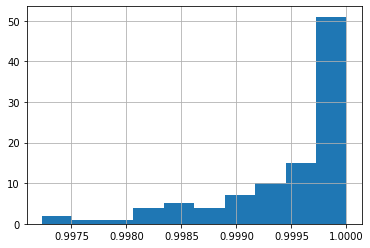

In [25]:
comparison = pd.DataFrame()
comparison["Greedy_algo"] = greedy_sols
comparison["Optimal_sols"] = optimal_sols
comparison["Ratio"] = comparison["Greedy_algo"]/comparison["Optimal_sols"]

comparison["Ratio"].hist(bins=10)
comparison["Ratio"].describe()


,Greedy_times,Guroby_times
count,100.000000,100.000000
mean,0.000017,-0.000374
std,0.000861,0.000906
min,-0.003689,-0.006080
25%,-0.000233,-0.000776
50%,0.000013,-0.000280
75%,0.000239,0.000021
max,0.003941,0.002035


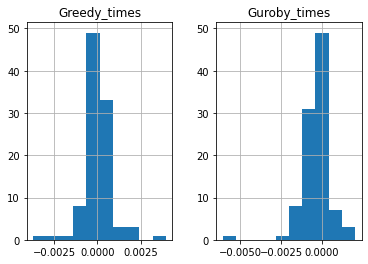

In [26]:
time_comparison = pd.DataFrame()
time_comparison["Greedy_times"] = greedy_times
time_comparison["Guroby_times"] = guroby_times


time_comparison.hist(bins=10)
time_comparison.describe()

# Bounds!

Lower and upper bound:

In [ ]:
lb = 
ub = 